# DAT 435 Final Project 
## Drought and Wildfires in the US
### By: Philip Krause

In [1]:
# Importing necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\phikr\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Getting border geometries
url_county = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip'
url_state = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip'

county_gdf = gpd.read_file(url_county)
state_gdf = gpd.read_file(url_state)

# Changing the crs of borders
county_gdf = county_gdf.to_crs(5070)
state_gdf = state_gdf.to_crs(5070)

# Using only the CONUS
exclude_list = [15, 72, 2, 60, 66, 69, 78]
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]
county_gdf = county_gdf.loc[~county_gdf['STATEFP'].astype(int).isin(exclude_list)]

# Combining county and state FPs
county_gdf['FIPS'] = county_gdf.STATEFP + county_gdf.COUNTYFP

In [3]:
fire_df = pd.read_csv('National_USFS_Fire_Occurrence_Point_(Feature_Layer).csv')

# To get rid of any warnings and to simplify data, I will reduce it to these columns
fire_df = fire_df[['DISCOVERYDATETIME','FIREYEAR','TOTALACRES','LATDD83','LONGDD83']]
# Reduce to actual years
fire_df = fire_df[(fire_df['FIREYEAR'] > 1910) & (fire_df['FIREYEAR'] < 2026)]
# Make year values ints
fire_df['FIREYEAR'] = fire_df['FIREYEAR'].astype(int)

# This data includes LAT and LON values, so I will convert them to point geometries
fire_gdf = gpd.GeoDataFrame(fire_df, geometry = gpd.points_from_xy(fire_df.LONGDD83, fire_df.LATDD83), crs="EPSG:4326")

# Converting the crs to match my state geometries
fire_gdf = fire_gdf.to_crs('EPSG:5070') 
fire_gdf.head()

C:\Users\phikr\AppData\Local\Temp\ipykernel_3648\3493565169.py:1: DtypeWarning: Columns (5,11,12,13,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  fire_df = pd.read_csv('National_USFS_Fire_Occurrence_Point_(Feature_Layer).csv')


DISCOVERYDATETIME  FIREYEAR  TOTALACRES   LATDD83   LONGDD83  \
0  2016/10/22 00:00:01+00      2016        0.25  39.84611 -106.42778   
1  2016/08/07 00:00:01+00      2016        0.10  39.37278 -107.93556   
2  1997/07/26 00:00:01+00      1997        0.10  39.11833 -106.72333   
3  1993/08/23 00:00:01+00      1993        0.10  39.65667 -106.59000   
4  2020/10/14 13:16:01+00      2020        0.10  40.01929 -107.31731   

                           geometry  
0   POINT (-882544.776 1918202.572)  
1  POINT (-1016169.689 1880586.821)  
2   POINT (-916637.266 1839943.251)  
3   POINT (-898578.357 1898623.981)  
4   POINT (-955181.693 1946081.565)

In [4]:
# Making geometry that encapsulates the CONUS
from shapely.geometry import box

# From previous plot, I can see the rough dimensions needed
min_y, max_y = 0, 3500000
min_x, max_x = -2500000, 2500000

# Making it into a box
conus_box = box(minx=min_x, miny=min_y, maxx=max_x, maxy=max_y)

# Making it into a geo dataframe with same crs as data
box_gdf = gpd.GeoDataFrame(index=[0], geometry=[conus_box], crs=fire_gdf.crs)

# Intersecting with data to only get shared values
fire_gdf = gpd.overlay(fire_gdf, box_gdf, how="intersection")

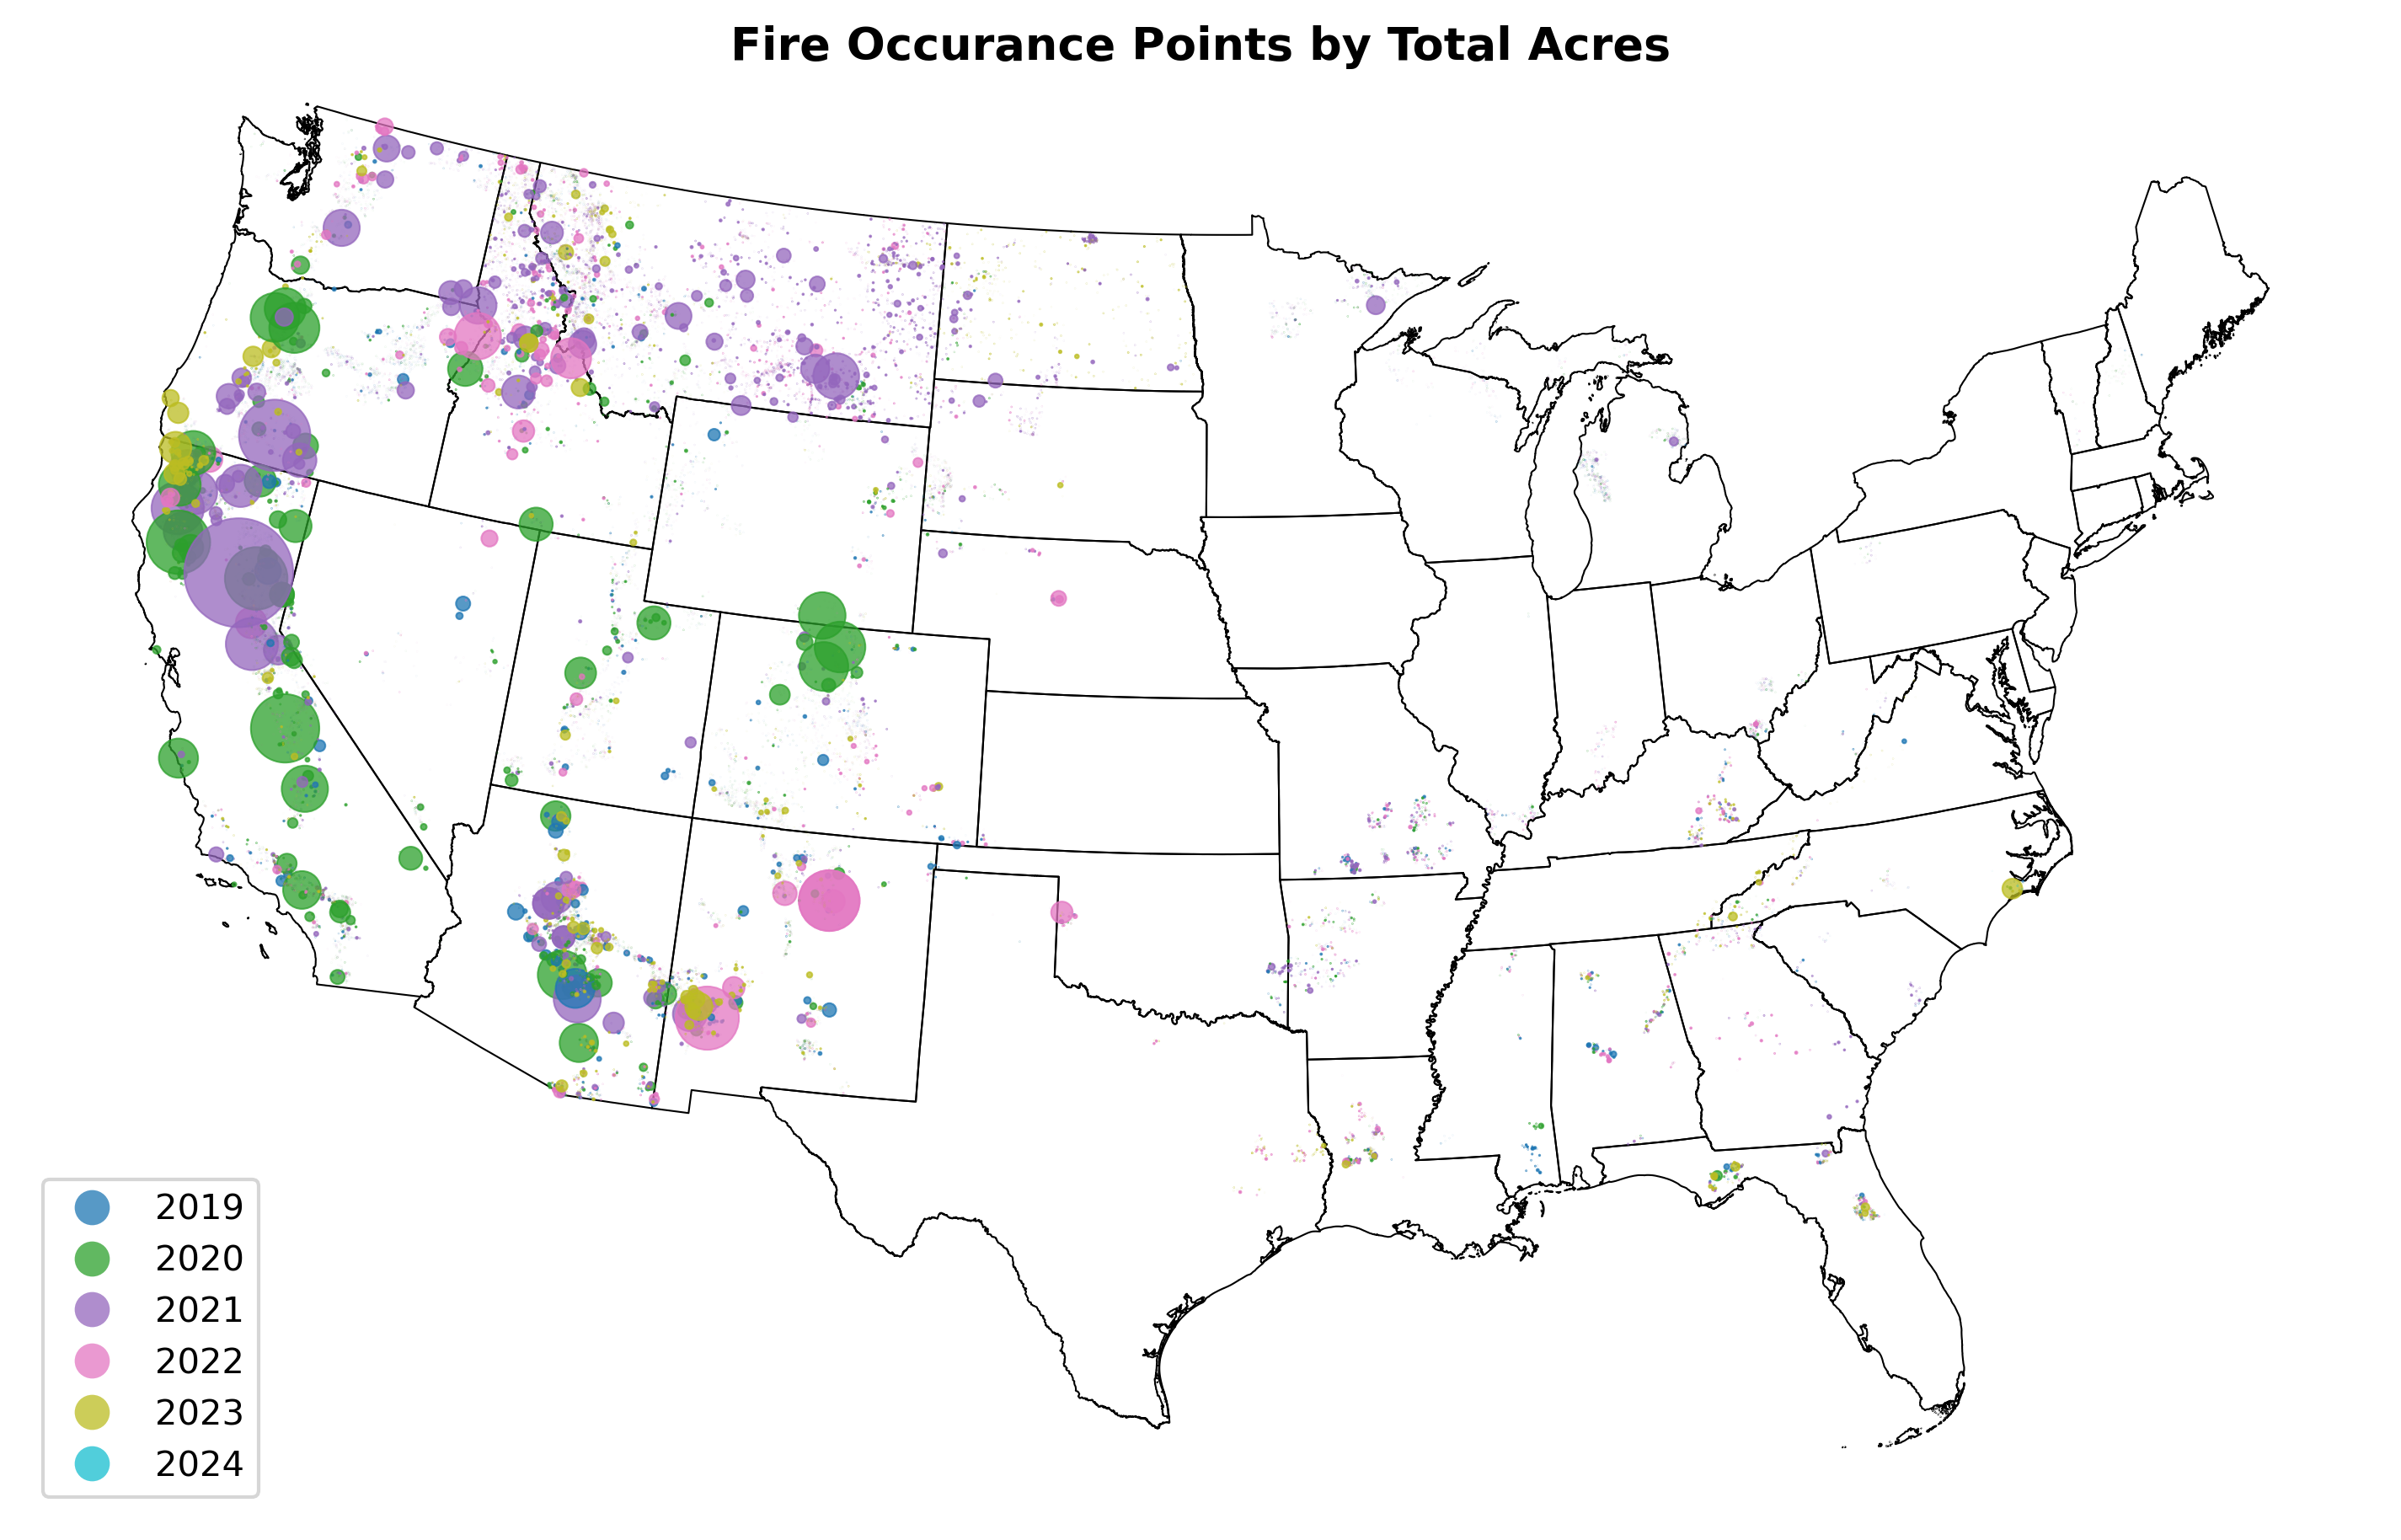

In [5]:
# Plotting all fires with markersize representing total acres affected and colors representing year

# There is a lot of data in this set, so I will just look at years 2019+
recent_fire_gdf = fire_gdf.copy()
recent_fire_gdf = recent_fire_gdf.loc[(fire_gdf['FIREYEAR']>2018) & (fire_gdf['FIREYEAR']<2026)]

fig, ax1 = plt.subplots(1, 1, figsize=(12, 12), dpi=300)

# Converting year to a string to make legend work correctly
recent_fire_gdf['FIREYEAR_STR'] = recent_fire_gdf['FIREYEAR'].astype(str)

state_gdf.plot(ax = ax1, linewidth = .5, edgecolor = 'black', facecolor='none')

recent_fire_gdf.plot(ax=ax1, column = 'FIREYEAR_STR', markersize = recent_fire_gdf['TOTALACRES']/1000, linewidth = 0.5, 
              edgecolor = 'face', alpha = 0.75, legend = True, aspect=1,  legend_kwds={'loc': 'lower left', 'fontsize': 10})

ax1.set_axis_off()
ax1.set_title('Fire Occurance Points by Total Acres', fontweight='bold', y=.97, fontsize=13);

In [6]:
# Creating 2021 gdf with values over 1,000 acres
twone_gdf = fire_gdf.loc[fire_gdf['FIREYEAR'] == 2021]
twone_gdf = twone_gdf.loc[twone_gdf['TOTALACRES'] > 1000]
twone_gdf = twone_gdf.sort_values(by='TOTALACRES', ascending = False)
twone_gdf.head()

DISCOVERYDATETIME  FIREYEAR  TOTALACRES   LATDD83   LONGDD83  \
569961  2021/07/14 00:15:02+00      2021    963309.0  39.87600 -121.37883   
442558  2021/07/06 13:42:00+00      2021    413717.0  42.61592 -121.42091   
304927  2021/07/31 01:10:00+00      2021    223124.0  40.75228 -123.33680   
273625  2021/08/14 00:00:00+00      2021    221835.0  38.61643 -120.58883   
164289  2021/06/04 14:37:00+00      2021    180757.0  33.21234 -111.12351   

                                geometry  
569961   POINT (-2125853.79 2158639.509)  
442558  POINT (-2048228.149 2455374.929)  
304927  POINT (-2257632.471 2298217.683)  
273625  POINT (-2097306.437 2004769.495)  
164289  POINT (-1394829.337 1238216.215)

In [7]:
# Reading data from link
url_name = r'https://droughtmonitor.unl.edu/data/shapefiles_m/USDM_20210713_M.zip'

drought_twone_gdf = gpd.read_file(url_name)

# Adding explanations of drought levels to data frame
DM_dict = {0: '0: Abnormally Dry', 1: '1: Moderate Drought', 2: '2: Severe Drought',
             3: '3: Extreme Drought', 4: '4: Exceptional Drought'}

drought_twone_gdf['DM_str'] = [DM_dict[i] for i in drought_twone_gdf['DM'].values]

drought_twone_gdf.head()

OBJECTID  DM    Shape_Leng    Shape_Area  \
0         1   0  4.450497e+07  1.119648e+12   
1         2   1  3.656680e+07  7.386279e+11   
2         3   2  3.666712e+07  1.006820e+12   
3         4   3  3.167702e+07  1.113286e+12   
4         5   4  1.313748e+07  7.693401e+11   

                                            geometry                  DM_str  
0  MULTIPOLYGON (((-67.17698 18.00918, -67.17753 ...       0: Abnormally Dry  
1  MULTIPOLYGON (((-66.90909 17.95065, -66.90948 ...     1: Moderate Drought  
2  MULTIPOLYGON (((-104.22221 30.68503, -104.0589...       2: Severe Drought  
3  MULTIPOLYGON (((-103.47122 33.13241, -103.5586...      3: Extreme Drought  
4  MULTIPOLYGON (((-104.84586 32.21714, -104.9626...  4: Exceptional Drought

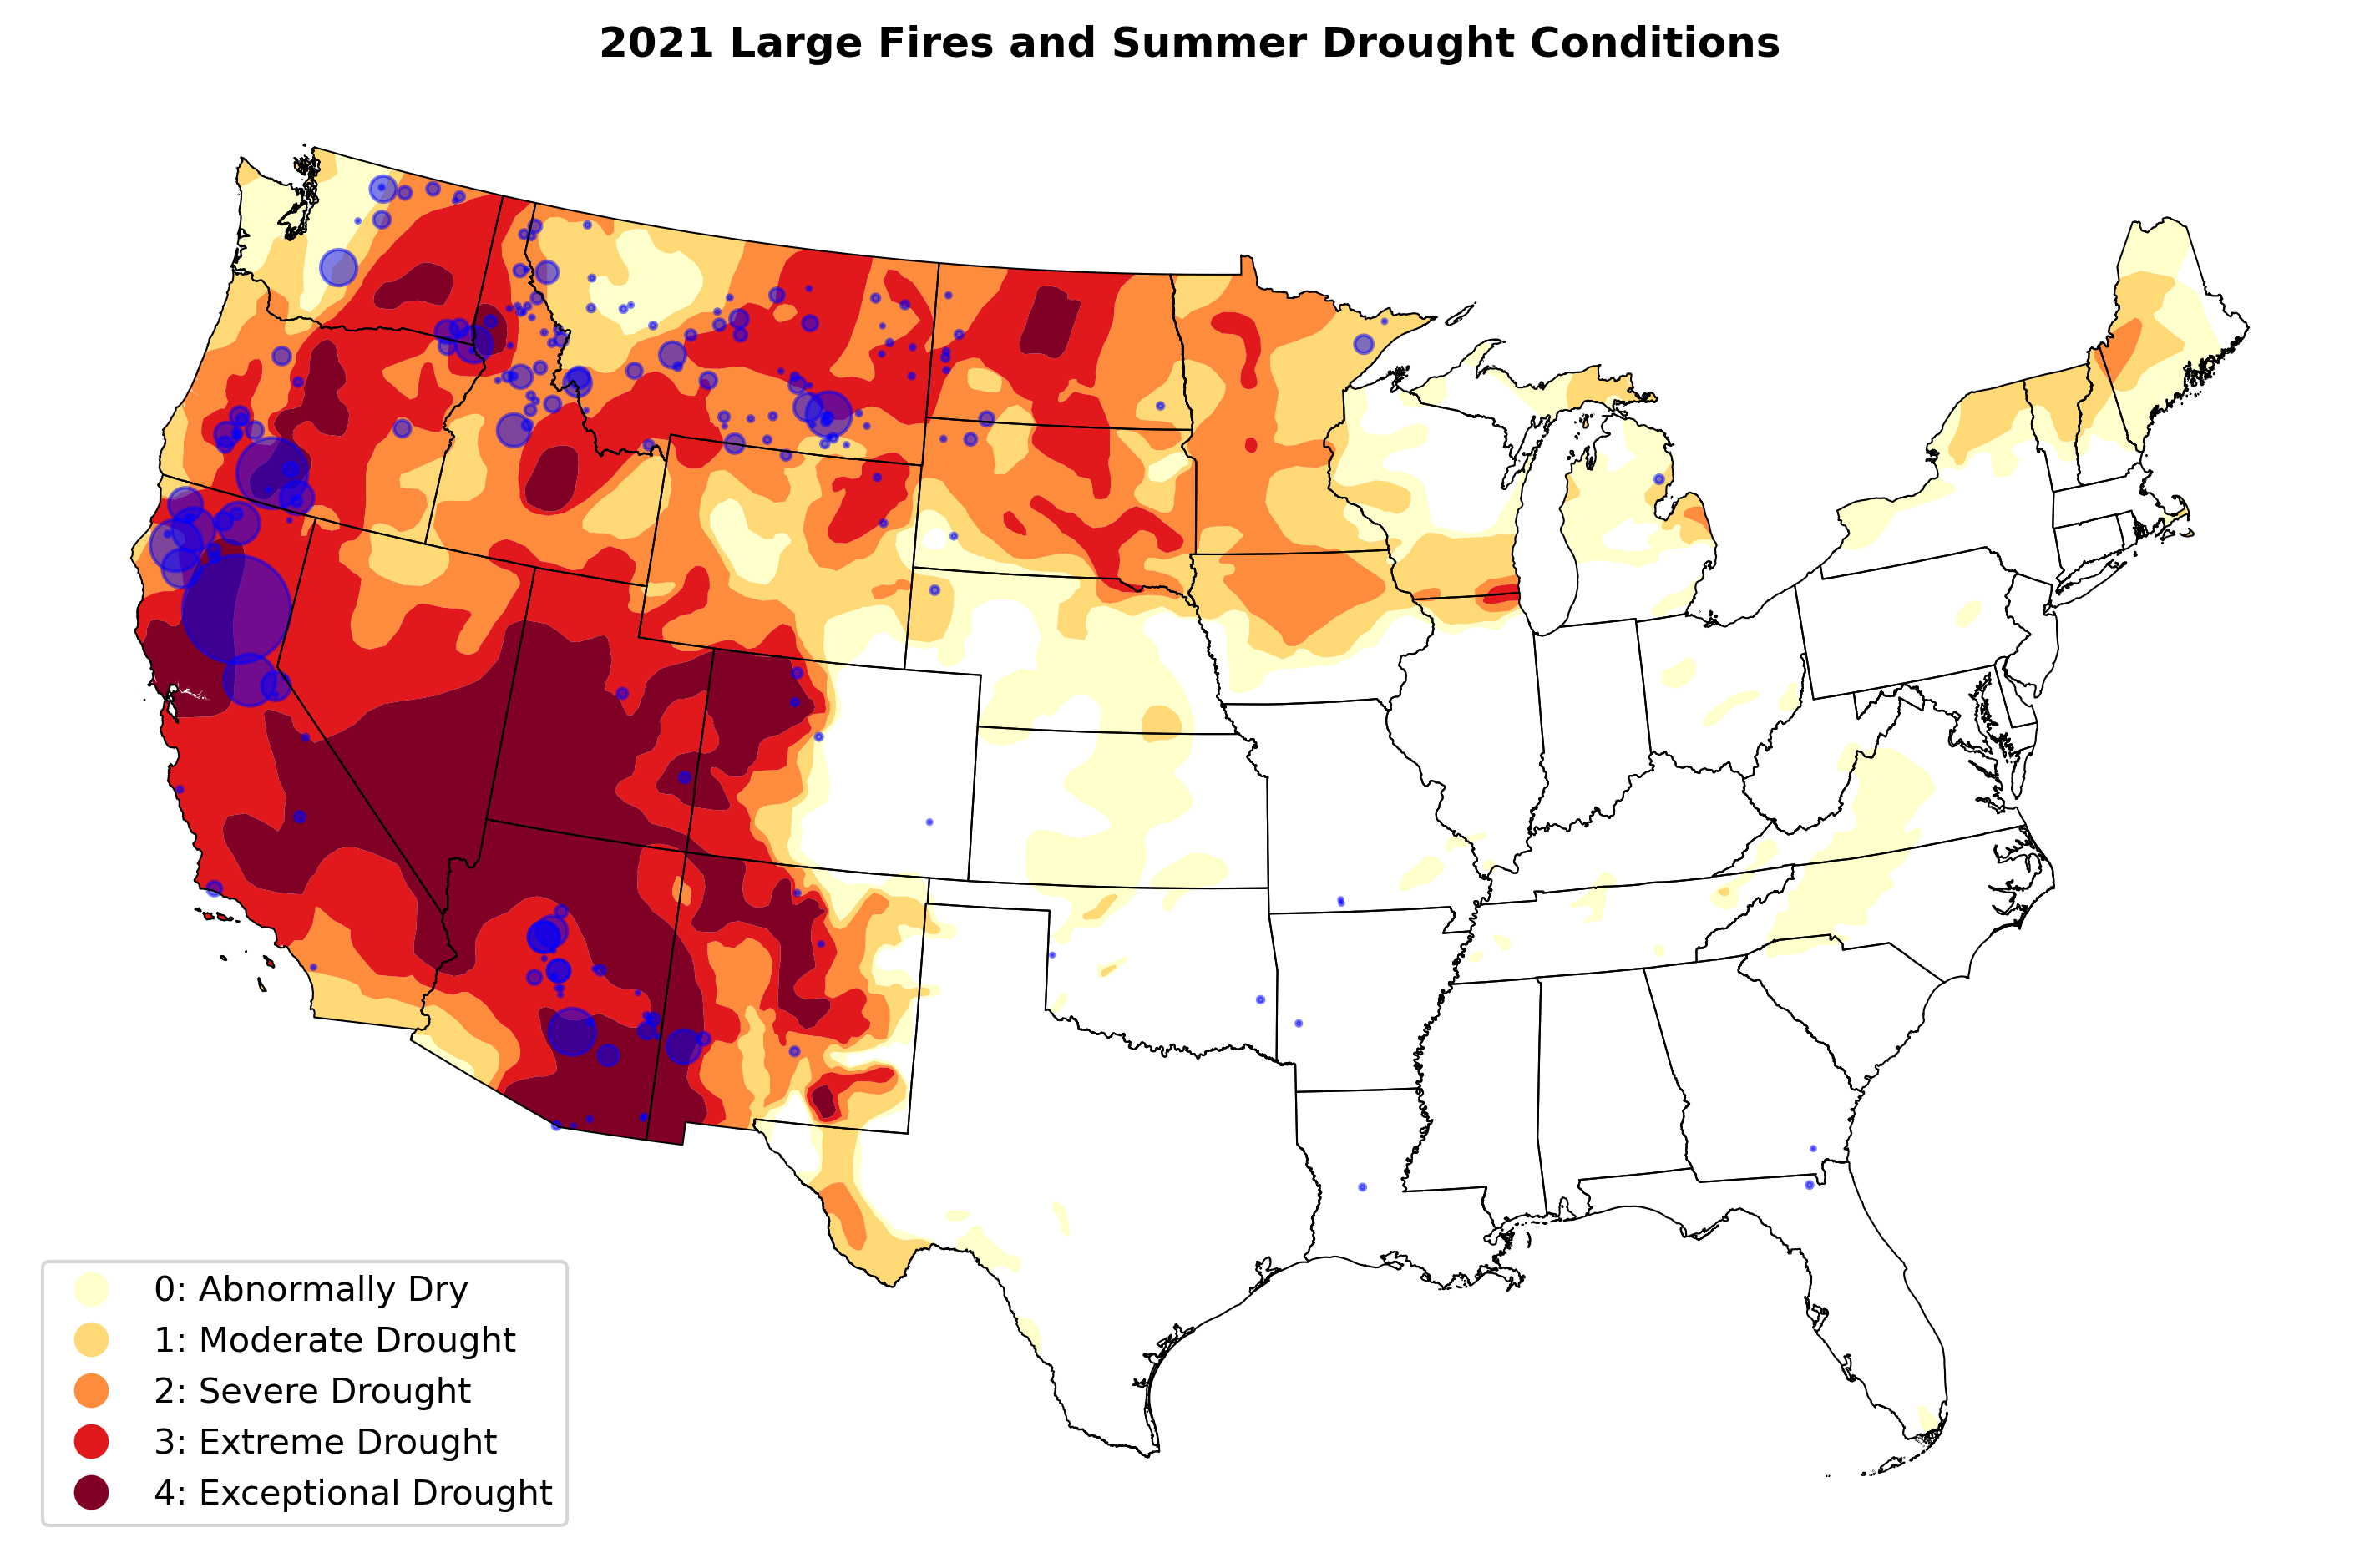

In [8]:
# Making sure crs is correct and then overlaying data with CONUS
drought_twone_gdf = drought_twone_gdf.to_crs('EPSG:5070')
drought_twone_gdf = gpd.overlay(drought_twone_gdf, box_gdf, how="intersection")

# Plotting drought and fire data in same plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12), dpi=300)

drought_twone_gdf.plot(ax = ax1, column = 'DM_str',legend=True, cmap = 'YlOrRd', 
                       legend_kwds={'loc': 'lower left', 'fontsize': 10})

twone_gdf.plot(ax=ax1, markersize = twone_gdf['TOTALACRES']/1000, alpha = 0.5, color = 'blue')
state_gdf.plot(ax = ax1, linewidth = .5, edgecolor = 'black', facecolor='none')

ax1.set_title('2021 Large Fires and Summer Drought Conditions', weight= 'bold')
ax1.set_axis_off()

In [9]:
ten_gdf = fire_gdf.loc[fire_gdf['FIREYEAR'] == 2010]
ten_gdf = ten_gdf.loc[ten_gdf['TOTALACRES'] > 1000]
ten_gdf = ten_gdf.sort_values(by='TOTALACRES', ascending = False)
ten_gdf.head()

DISCOVERYDATETIME  FIREYEAR  TOTALACRES   LATDD83   LONGDD83  \
182714  2010/07/20 12:02:00+00      2010     44892.0  38.42528 -112.49917   
366926  2010/07/10 14:30:00+00      2010     19291.0  47.57583 -120.34750   
143298  2010/06/10 00:00:00+00      2010     17100.0  36.05582 -106.44969   
330863  2010/07/26 00:00:00+00      2010     16442.0  35.78528 -118.47472   
116754  2010/06/20 00:00:00+00      2010     15075.0  35.28639 -111.62380   

                                geometry  
182714  POINT (-1419686.407 1834042.129)  
366926  POINT (-1823914.184 2966280.425)  
143298   POINT (-931001.878 1496225.901)  
330863  POINT (-1994844.704 1651683.868)  
116754  POINT (-1402615.012 1474406.067)

In [10]:
url_name = r'https://droughtmonitor.unl.edu/data/shapefiles_m/USDM_20100713_M.zip'

drought_ten_gdf = gpd.read_file(url_name)

drought_ten_gdf['DM_str'] = [DM_dict[i] for i in drought_ten_gdf['DM'].values]

drought_ten_gdf.head()

OBJECTID  DM    Shape_Leng    Shape_Area  \
0         1   0  7.813893e+07  1.924223e+12   
1         2   1  2.507476e+07  5.113988e+11   
2         3   2  5.184110e+06  8.623613e+10   
3         4   3  1.293079e+06  2.364391e+10   
4         5   4  1.837148e+05  8.537582e+08   

                                            geometry                  DM_str  
0  MULTIPOLYGON (((-99.16971 29.96605, -99.18494 ...       0: Abnormally Dry  
1  MULTIPOLYGON (((-97.86395 31.70287, -97.84609 ...     1: Moderate Drought  
2  MULTIPOLYGON (((-91.05752 33.0104, -90.94171 3...       2: Severe Drought  
3  MULTIPOLYGON (((-92.5126 31.70631, -92.70678 3...      3: Extreme Drought  
4  MULTIPOLYGON (((-155.5104 19.1461, -155.50849 ...  4: Exceptional Drought

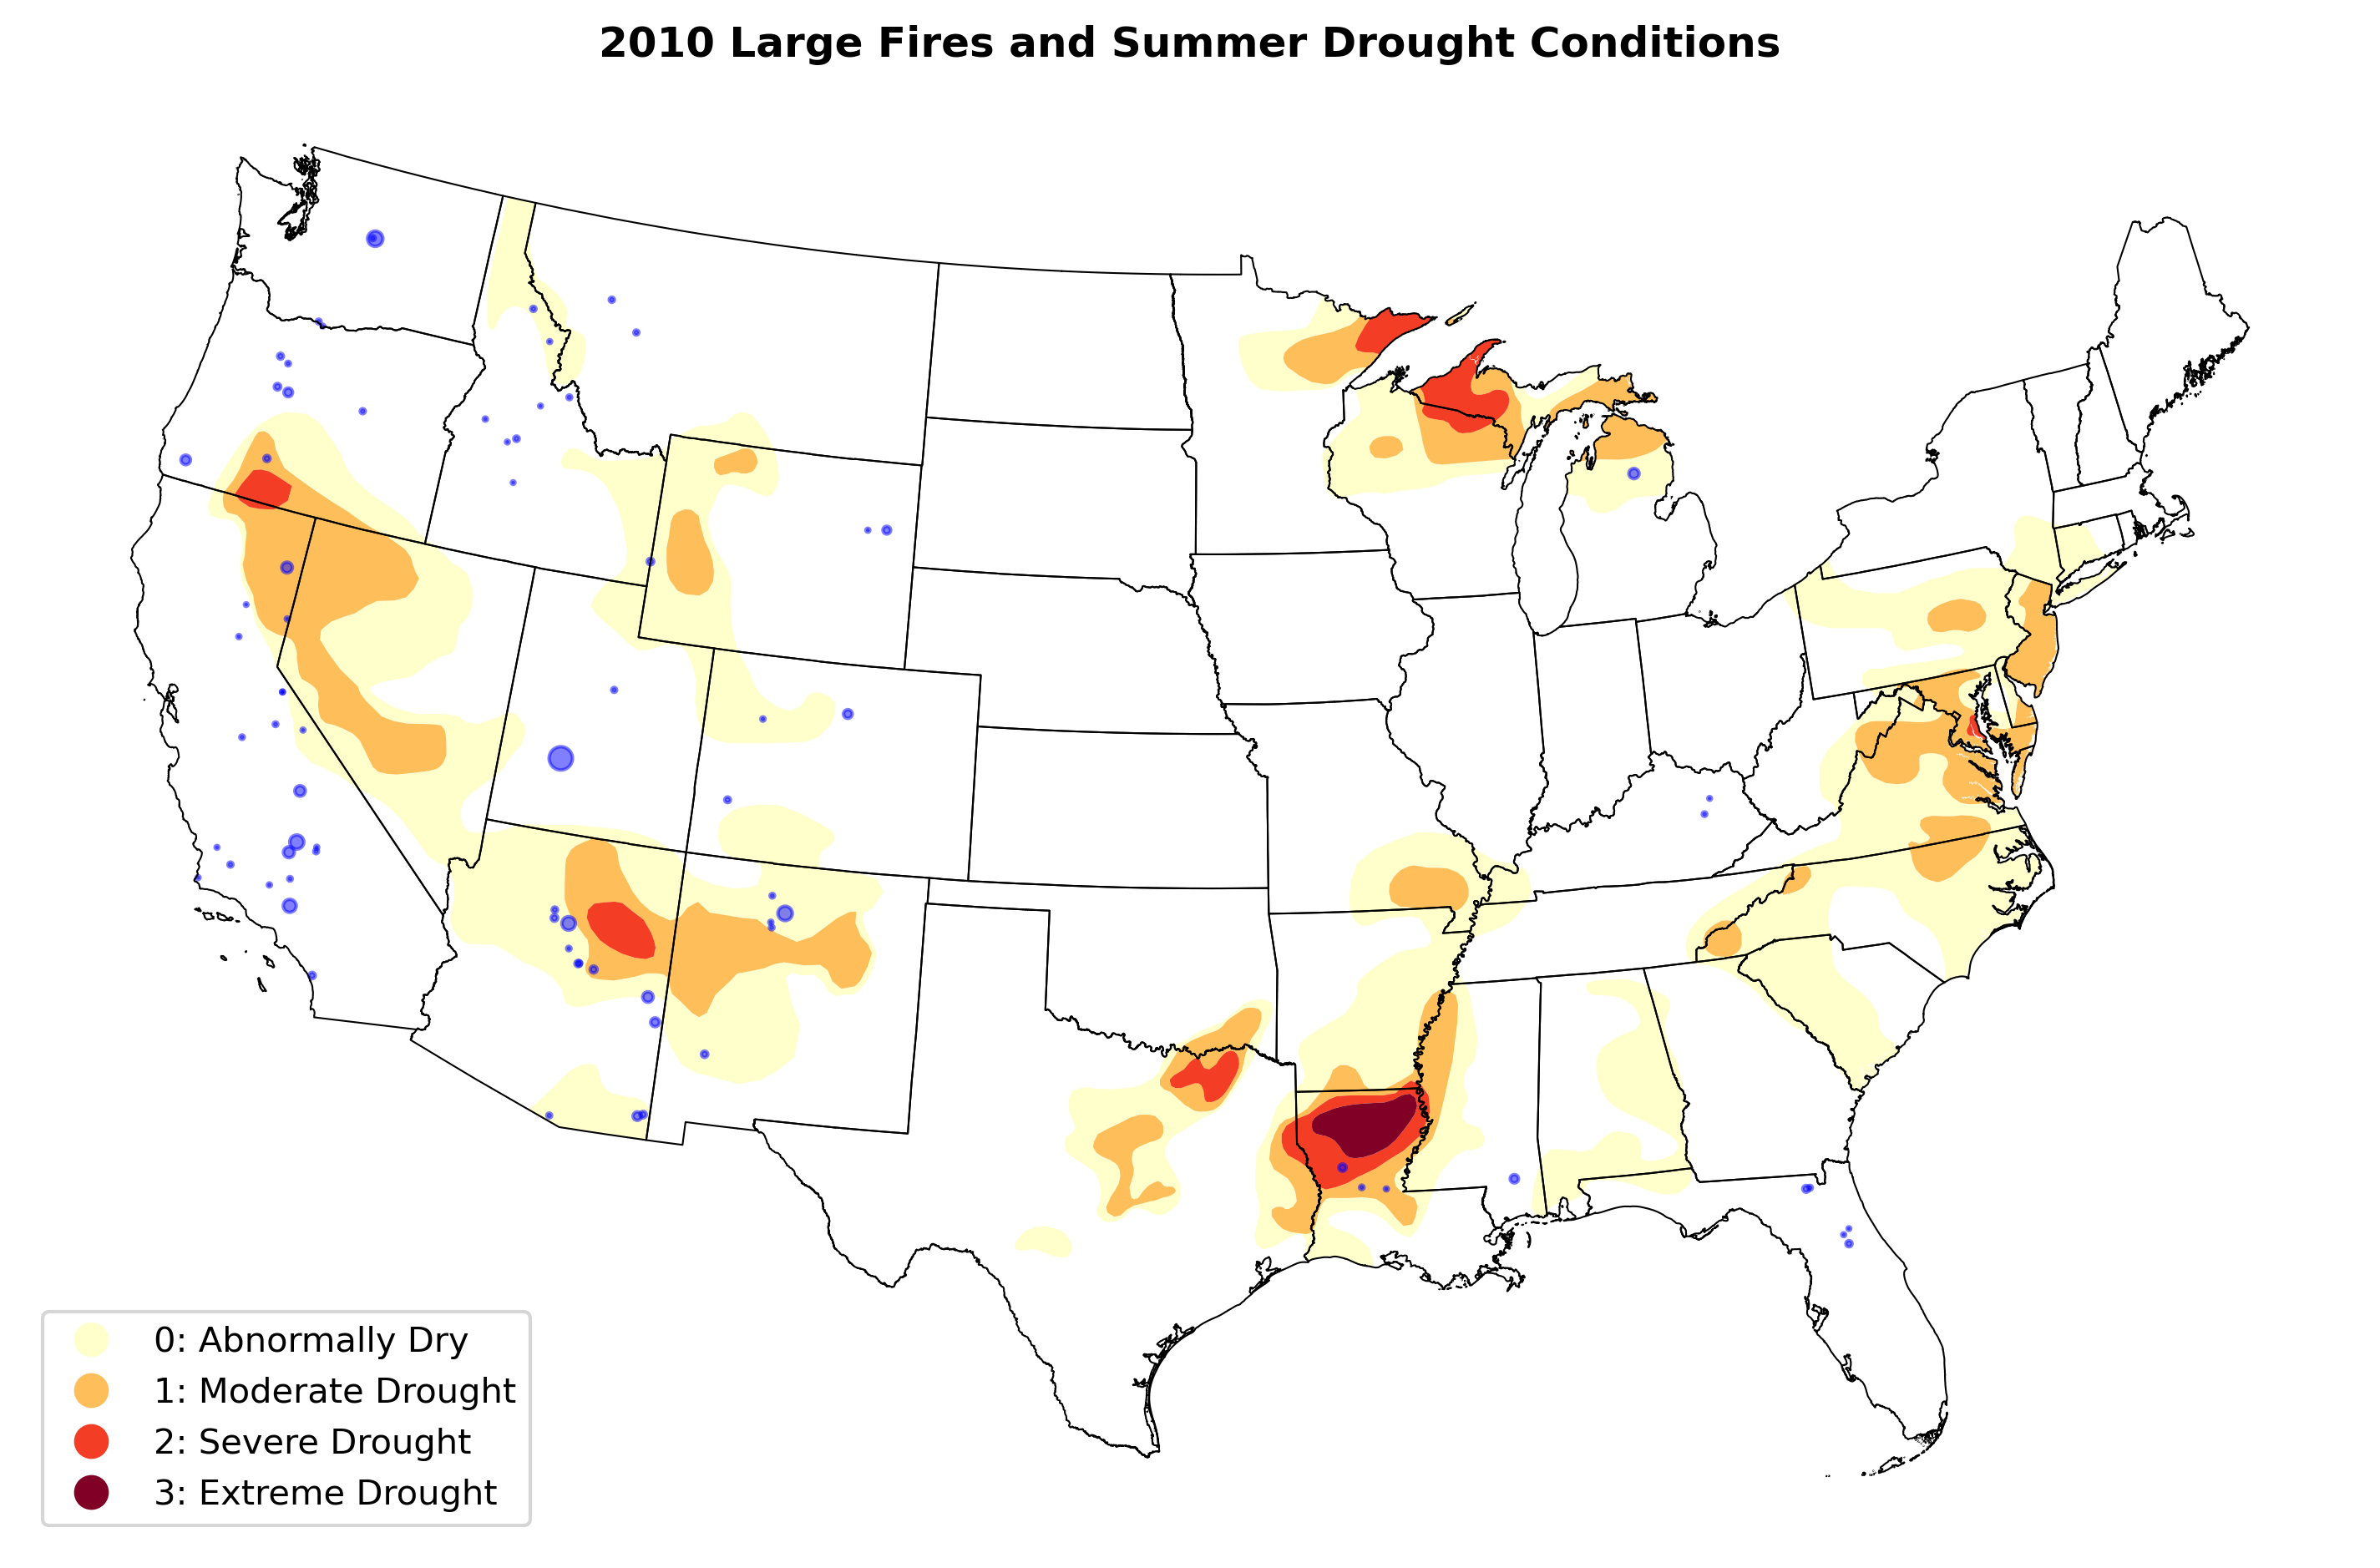

In [11]:
drought_ten_gdf = drought_ten_gdf.to_crs('EPSG:5070')
drought_ten_gdf = gpd.overlay(drought_ten_gdf, box_gdf, how="intersection")

fig, ax1 = plt.subplots(1, 1, figsize=(12, 12), dpi=300)

drought_ten_gdf.plot(ax = ax1, column = 'DM_str',legend = True, cmap = 'YlOrRd',
                      legend_kwds={'loc': 'lower left', 'fontsize': 10})
ten_gdf.plot(ax=ax1, markersize = ten_gdf['TOTALACRES']/1000, alpha = 0.5, color = 'blue')
state_gdf.plot(ax = ax1, linewidth = .5, edgecolor = 'black', facecolor='none')

ax1.set_title('2010 Large Fires and Summer Drought Conditions', weight= 'bold')
ax1.set_axis_off()

In [12]:
zero_gdf = fire_gdf.loc[fire_gdf['FIREYEAR'] == 2000]
zero_gdf = zero_gdf.loc[zero_gdf['TOTALACRES'] > 1000]
zero_gdf = zero_gdf.sort_values(by='TOTALACRES', ascending = False)
zero_gdf.head()

DISCOVERYDATETIME  FIREYEAR  TOTALACRES   LATDD83   LONGDD83  \
216043  2000/07/10 00:00:00+00      2000    172135.0  45.22167 -114.49500   
213824  2000/07/31 00:00:00+00      2000    149772.0  45.15131 -115.18674   
95700                      NaN      2000    145040.0  45.96417 -114.01722   
25071   2000/08/24 00:00:00+00      2000     83508.0  43.73170 -103.88670   
493036  2000/07/22 00:00:00+00      2000     75000.0  35.86778 -118.28389   

                                geometry  
216043  POINT (-1442410.044 2611184.078)  
213824  POINT (-1497206.099 2614209.966)  
95700    POINT (-1390054.014 2685048.56)  
25071     POINT (-632026.474 2330632.75)  
493036  POINT (-1976073.445 1656679.427)

In [13]:
url_name = r'https://droughtmonitor.unl.edu/data/shapefiles_m/USDM_20000718_M.zip'

drought_zero_gdf = gpd.read_file(url_name)

drought_zero_gdf['DM_str'] = [DM_dict[i] for i in drought_zero_gdf['DM'].values]

drought_zero_gdf.head()

OBJECTID  DM    Shape_Leng    Shape_Area  \
0         1   0  3.647263e+07  2.376510e+12   
1         2   1  2.265833e+07  1.066835e+12   
2         3   2  1.139253e+07  2.665891e+11   
3         4   3  7.404335e+06  2.611181e+11   
4         5   4  7.804344e+06  1.649494e+11   

                                            geometry                  DM_str  
0  MULTIPOLYGON (((-66.52045 17.8897, -66.52909 1...       0: Abnormally Dry  
1  MULTIPOLYGON (((-66.75891 17.98563, -66.76306 ...     1: Moderate Drought  
2  MULTIPOLYGON (((-82.49607 27.82494, -82.49711 ...       2: Severe Drought  
3  MULTIPOLYGON (((-82.81583 28.0149, -82.82516 2...      3: Extreme Drought  
4  MULTIPOLYGON (((-89.32593 29.09266, -89.3276 2...  4: Exceptional Drought

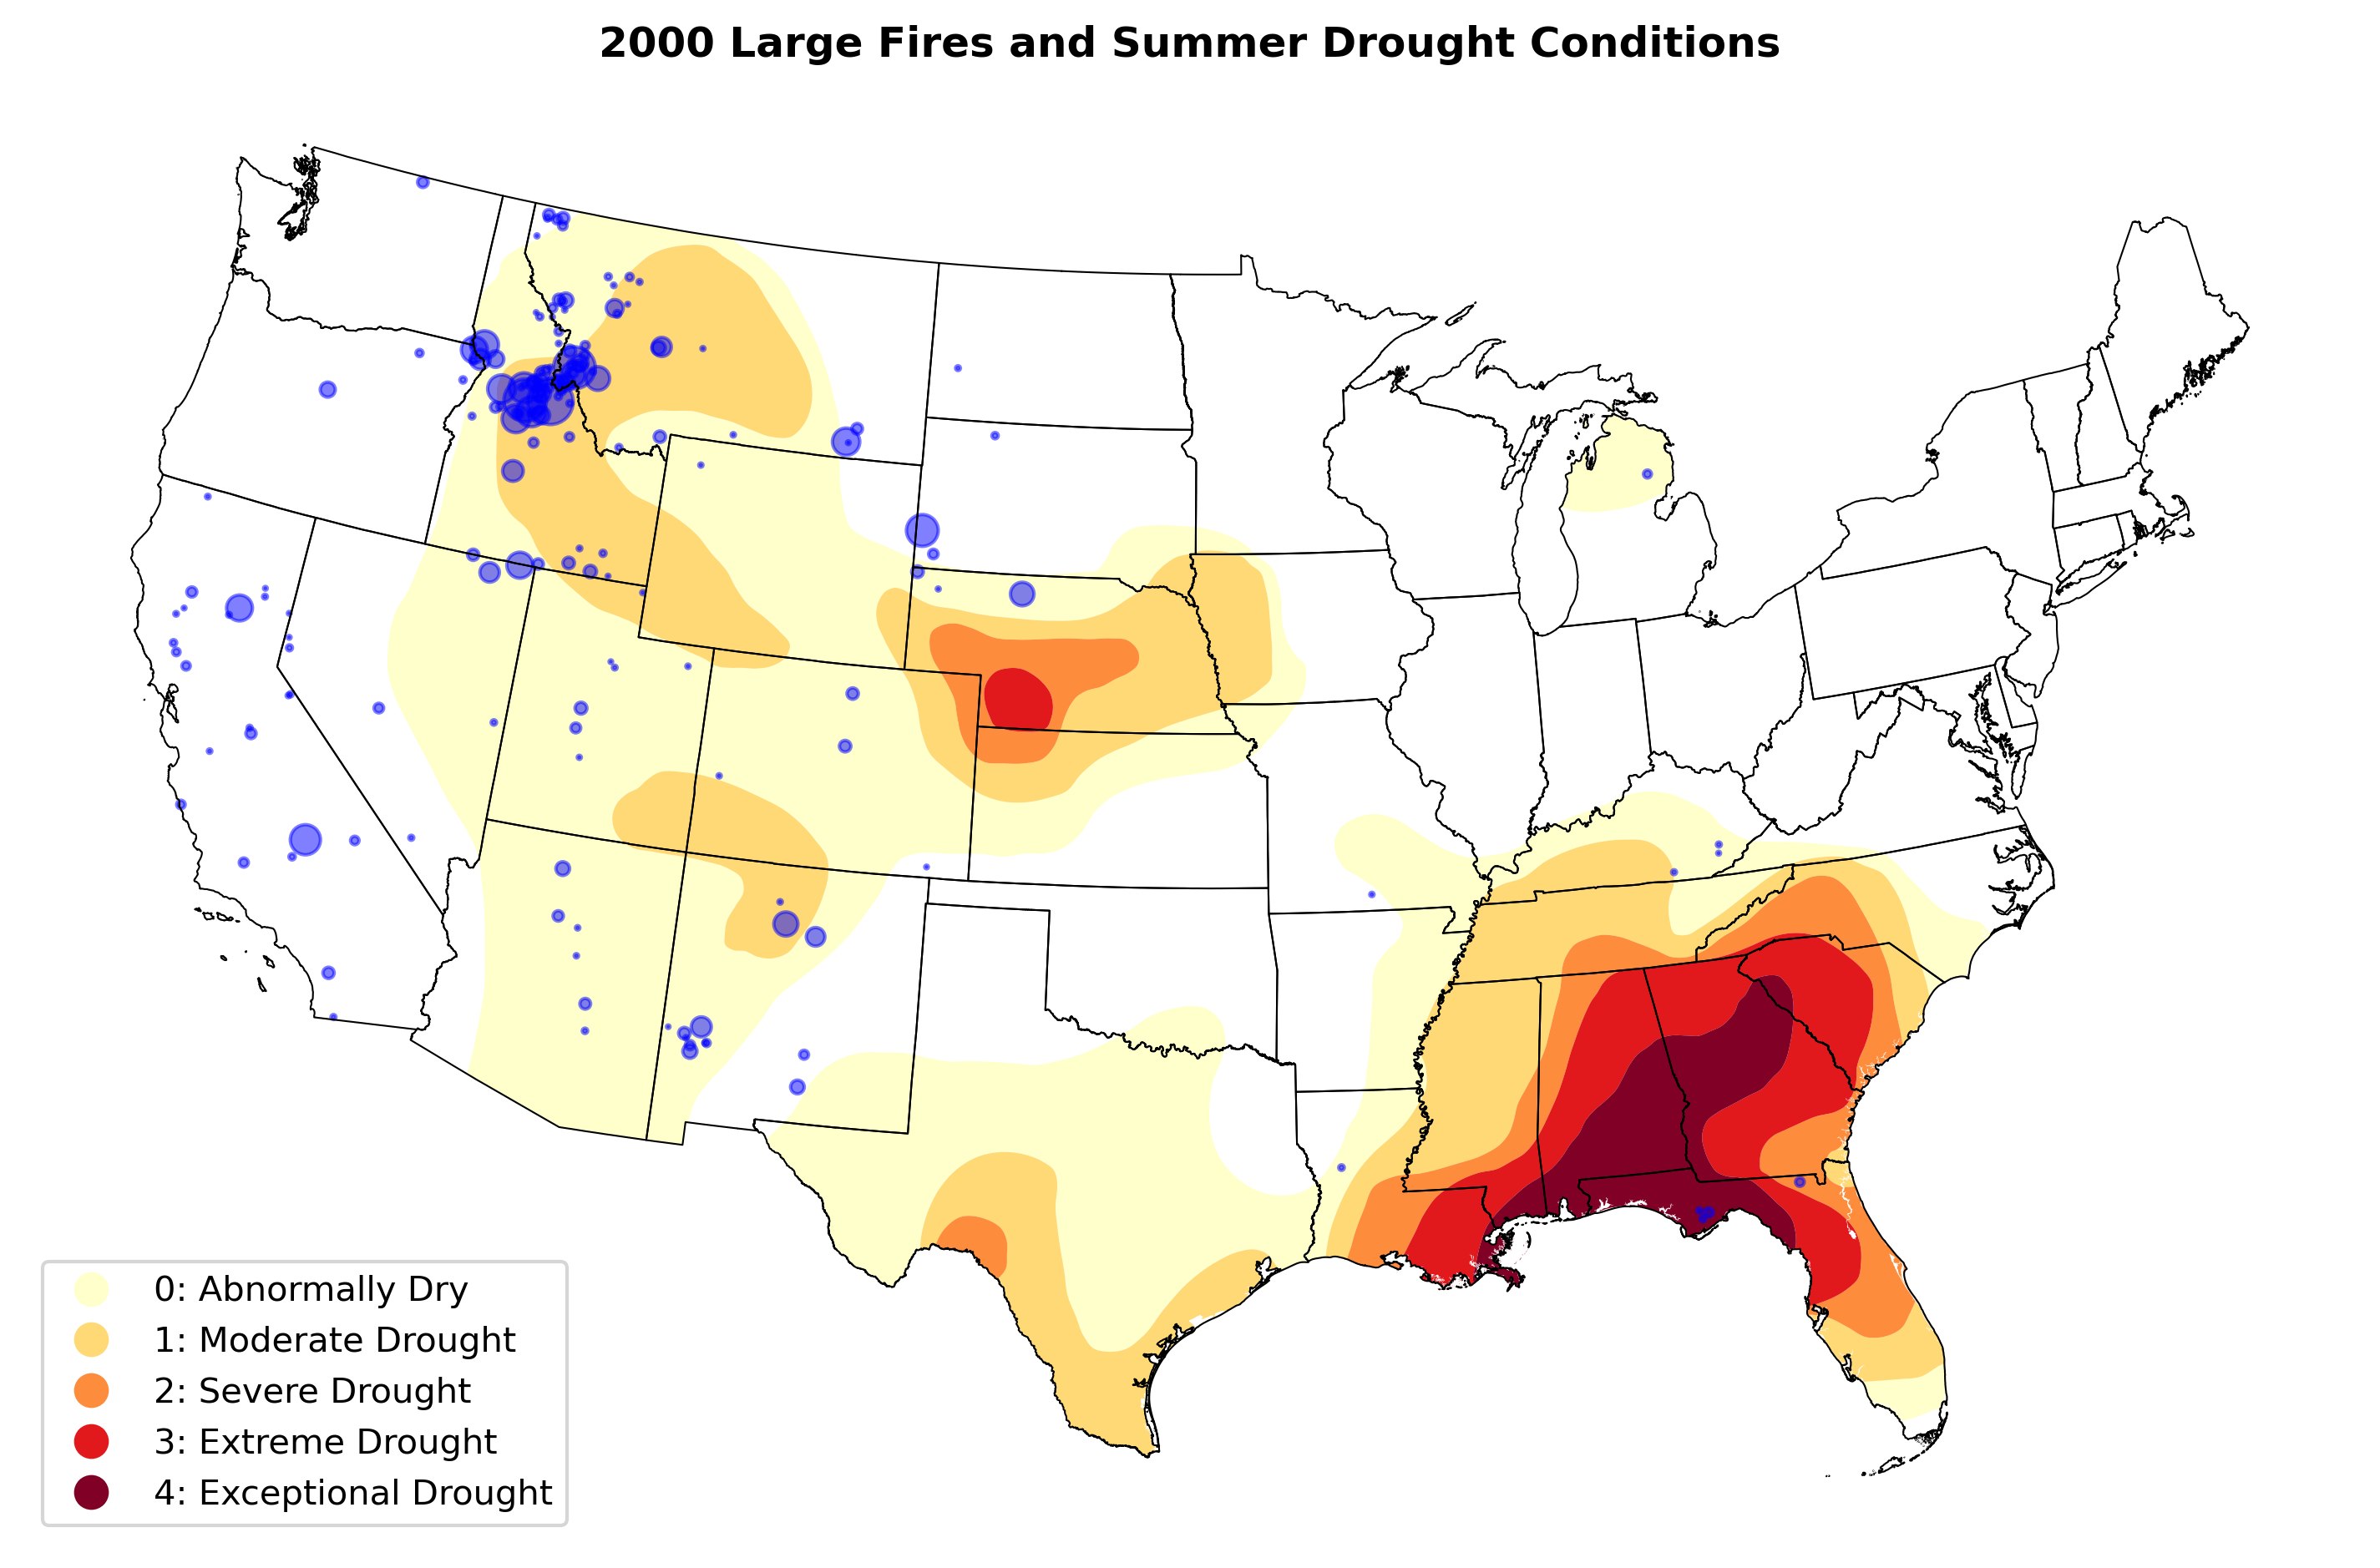

In [14]:
drought_zero_gdf = drought_zero_gdf.to_crs('EPSG:5070')
drought_zero_gdf = gpd.overlay(drought_zero_gdf, box_gdf, how="intersection")

fig, ax1 = plt.subplots(1, 1, figsize=(12, 12), dpi=300)

drought_zero_gdf.plot(ax = ax1, column = 'DM_str',legend = True, cmap = 'YlOrRd',
                      legend_kwds={'loc': 'lower left', 'fontsize': 10})
zero_gdf.plot(ax=ax1, markersize = zero_gdf['TOTALACRES']/1000, alpha = 0.5, color = 'blue')
state_gdf.plot(ax = ax1, linewidth = .5, edgecolor = 'black', facecolor='none')

ax1.set_title('2000 Large Fires and Summer Drought Conditions', weight= 'bold')
ax1.set_axis_off()

In [15]:
#Reading county drought data
drought_county_df = pd.read_csv('2021_county_drought.csv')

drought_county_df.head()

MapDate  FIPS                      County State    None     D0   D1   D2  \
0  20210713  2013      Aleutians East Borough    AK  100.00   0.00  0.0  0.0   
1  20210713  2016  Aleutians West Census Area    AK   98.98   1.02  0.0  0.0   
2  20210713  2020      Anchorage Municipality    AK   12.76  87.24  0.0  0.0   
3  20210713  2050          Bethel Census Area    AK   87.48  12.52  0.0  0.0   
4  20210713  2060         Bristol Bay Borough    AK  100.00   0.00  0.0  0.0   

    D3   D4  ValidStart    ValidEnd  StatisticFormatID  
0  0.0  0.0  2021-07-13  2021-07-19                  1  
1  0.0  0.0  2021-07-13  2021-07-19                  1  
2  0.0  0.0  2021-07-13  2021-07-19                  1  
3  0.0  0.0  2021-07-13  2021-07-19                  1  
4  0.0  0.0  2021-07-13  2021-07-19                  1

In [16]:
# Creating an average drought level that will be used in analysis
drought_county_df['D_avg'] = (((drought_county_df['D0']/100)*1) + ((drought_county_df['D1']/100)*2) 
                              + ((drought_county_df['D2']/100)*3) + ((drought_county_df['D3']/100)*2) 
                              + ((drought_county_df['D4']/100)*5))

# Converting FIPS to string to be able to merge 
drought_county_df['FIPS'] = drought_county_df['FIPS'].astype(str)
# Merging county data with county drought data
drought_county_gdf = county_gdf.merge(drought_county_df, left_on='FIPS', right_on='FIPS', how='left')

In [17]:
# Making 2021 gdf with all fire points, not just large
twone_all_gdf = fire_gdf.loc[fire_gdf['FIREYEAR'] == 2021]

# Joining fire data with county gdf to total fire acreage by county
county_fires = gpd.sjoin(twone_all_gdf, county_gdf, how="left", predicate="within")
# This is used just to see how many fires were in the county
county_fires['TOTALFIRES'] = 1
county_fires = county_fires[['TOTALACRES','FIPS','TOTALFIRES']]

county_fires = county_fires.groupby(['FIPS']).sum()
county_fires = county_fires.reset_index()

# Finally, merging datasets to get all info in one dataset
county_fires_gdf = drought_county_gdf.merge(county_fires, left_on='FIPS', right_on='FIPS', how='left')
county_fires_gdf.head()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID       NAME  \
0      20      161  00485044  0500000US20161  20161      Riley   
1      19      159  00465268  0500000US19159  19159   Ringgold   
2      30      009  01720111  0500000US30009  30009     Carbon   
3      16      007  00395090  0500000US16007  16007  Bear Lake   
4      55      011  01581065  0500000US55011  55011    Buffalo   

           NAMELSAD STUSPS STATE_NAME LSAD  ...      D1      D2    D3   D4  \
0      Riley County     KS     Kansas   06  ...    0.00    0.00   0.0  0.0   
1   Ringgold County     IA       Iowa   06  ...    0.00    0.00   0.0  0.0   
2     Carbon County     MT    Montana   06  ...  100.00  100.00   4.9  0.0   
3  Bear Lake County     ID      Idaho   06  ...  100.00   99.15  22.1  0.0   
4    Buffalo County     WI  Wisconsin   06  ...   49.48    0.00   0.0  0.0   

   ValidStart    ValidEnd StatisticFormatID   D_avg  TOTALACRES  TOTALFIRES  
0  2021-07-13  2021-07-19               1.0  0.3177         NaN         NaN  
1  2021-07-13  2021-07-19               1.0  0.0000         NaN         NaN  
2  2021-07-13  2021-07-19               1.0  6.0980    36550.01        34.0  
3  2021-07-13  2021-07-19               1.0  6.4165        0.90         7.0  
4  2021-07-13  2021-07-19               1.0  1.9896         NaN         NaN  

[5 rows x 29 columns]

In [18]:
# Changing NaN values to 0
county_fires_gdf['TOTALACRES'] = county_fires_gdf['TOTALACRES'].fillna(0)
county_fires_gdf['TOTALFIRES'] = county_fires_gdf['TOTALFIRES'].fillna(0)

# Normalizing fire data based on the area of the county
county_fires_gdf['norm_acres'] = county_fires_gdf['TOTALACRES'] / county_fires_gdf['ALAND']
county_fires_gdf['norm_fires'] = county_fires_gdf['TOTALFIRES'] / county_fires_gdf['ALAND']

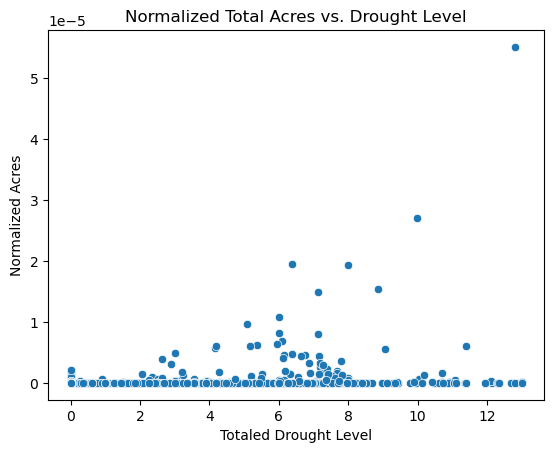

In [19]:
# Making scatterplot with drought average and normalized acres
sns.scatterplot(data=county_fires_gdf, x='D_avg', y='norm_acres')

plt.xlabel('Totaled Drought Level')
plt.ylabel('Normalized Acres')
plt.title('Normalized Total Acres vs. Drought Level')

plt.show()

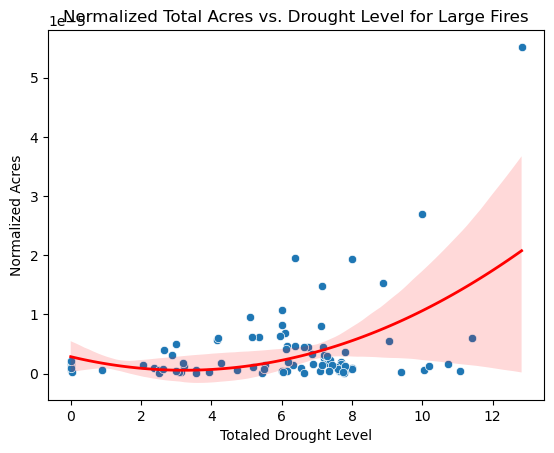

In [20]:
# Filtering fires that are more that 1000 total acres
filtered_gdf = county_fires_gdf[county_fires_gdf['TOTALACRES'] > 1000]

# Plotting
sns.scatterplot(data= filtered_gdf, x='D_avg', y='norm_acres')

# Plotting a 2nd degree regression line
sns.regplot(data=filtered_gdf, x='D_avg', y='norm_acres', scatter=False, color='red', line_kws={'lw': 2},order = 2)

plt.xlabel('Totaled Drought Level')
plt.ylabel('Normalized Acres')
plt.title('Normalized Total Acres vs. Drought Level for Large Fires')

plt.show()

In [21]:
# Grouping fire data by year, using sum to get total acres per year
yearly_fire_df = fire_df.copy
yearly_fire_df = fire_df.groupby(['FIREYEAR']).sum()
yearly_fire_df = yearly_fire_df.reset_index()
yearly_fire_df.head()

FIREYEAR  TOTALACRES     LATDD83    LONGDD83
0      1911        42.3  1513.72155 -3684.65144
1      1912        42.6   980.44002 -2624.20926
2      1913       125.6   969.65071 -2762.95447
3      1914       582.8   959.20390 -2533.61389
4      1915        92.7  1826.27194 -5012.77201

Text(0, 0.5, 'Total Acres of Fire')

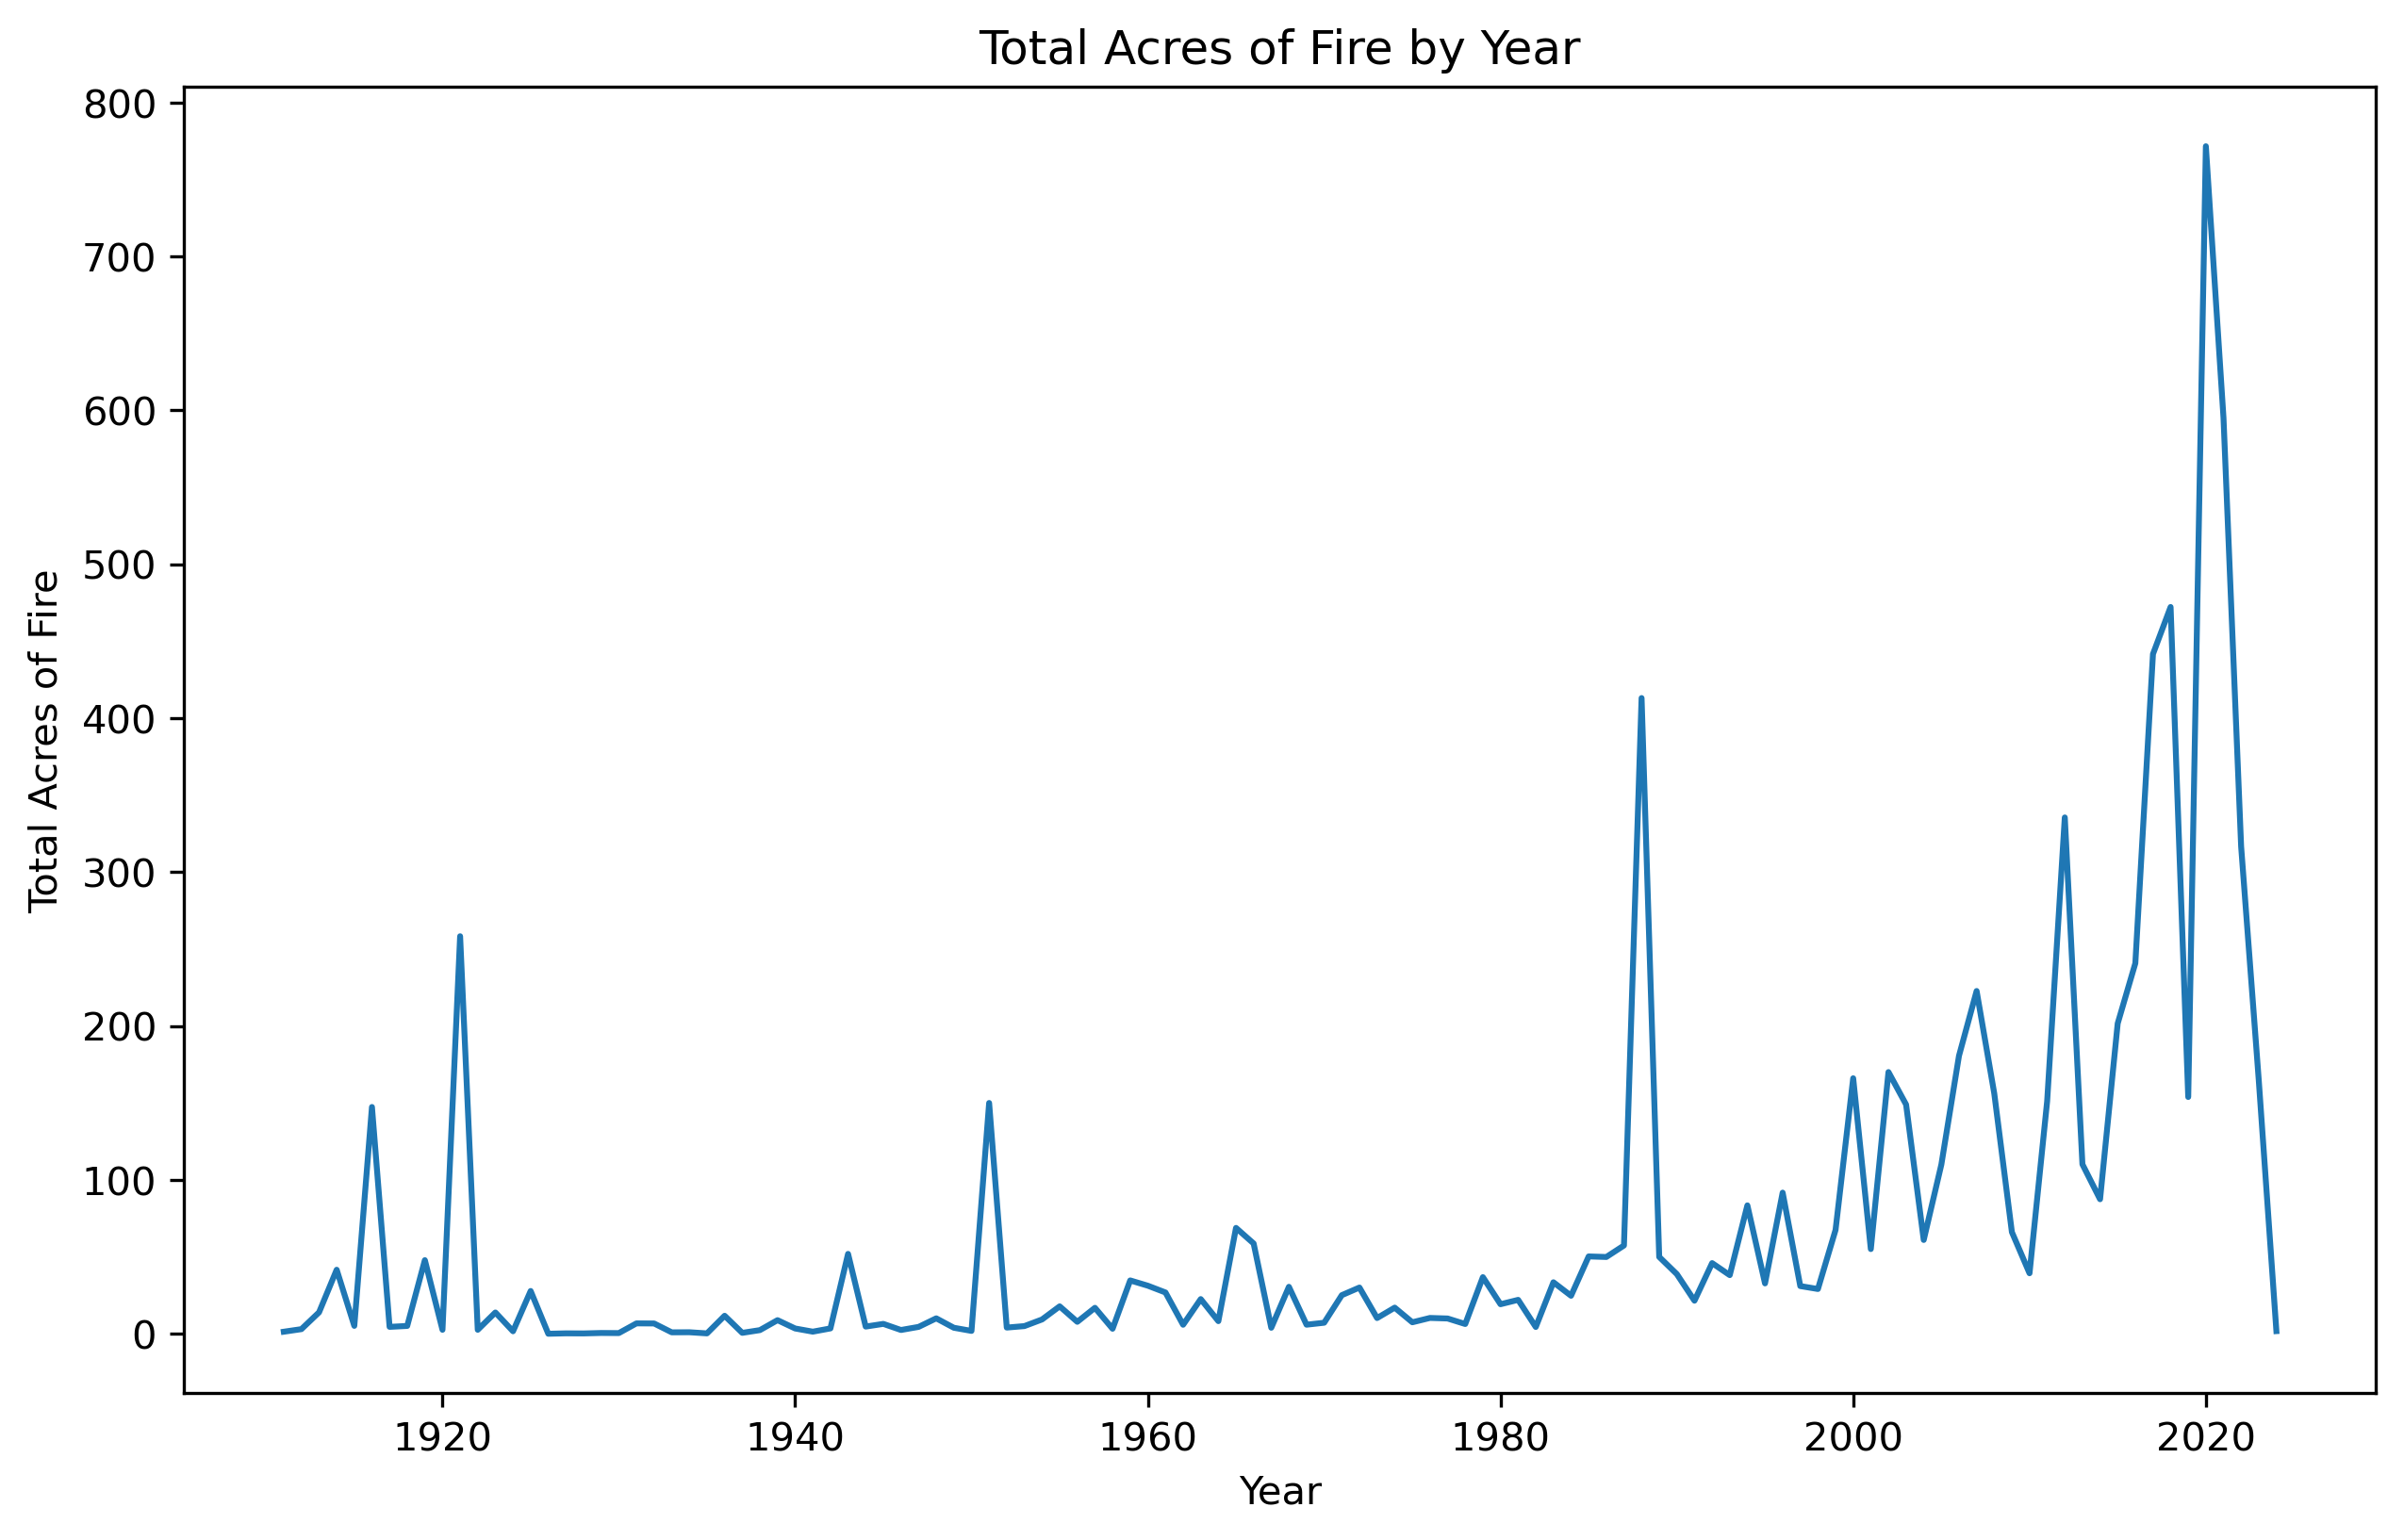

In [22]:
# Plotting total acres by year
fig, ax1 = plt.subplots(1,1, dpi = 300,figsize=(10, 6))
sns.lineplot(ax = ax1, data=fire_df, x='FIREYEAR', y='TOTALACRES',ci = None)
ax1.set_title('Total Acres of Fire by Year')
ax1.set_xlabel('Year')  
ax1.set_ylabel('Total Acres of Fire')